# 2AMM20 - Research Topics in Data Mining
#### NLP Track - Group 01


In [1]:
!pip install transformers
!pip install yellowbrick

In [2]:
%matplotlib inline  

In [1]:
import io
import re
import torch
import random
import math
import operator

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import isfile, join
from pathlib import Path
from tqdm.notebook import tqdm
from transformers import BertTokenizer, BertModel
from scipy.spatial.distance import cosine, cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer


## VERIFY VARIABLES (todo delete later.)

In [11]:
TEST_MODE = False  # if testing, used in some places. If using variable always put a TODO where you use it for easy removal.
BERT_DF_EXISTS = False

## Helper functions

In [18]:
def extract_sentences(word, data_df): 
  """
  Function that extracts sentences where word appears. 

  :param string word: word to find in data_df.
  :param dataframe data_df: dataframe that contains all sentences to look for word.
  :return: two lists [original_index], [sentence] 
          original_index states the location of sentence in data_df 
          sentence states the sentence 
  """
  found_data_df = data_df[data_df['citation-string'].str.contains(r"\b{0}\b".format(word), case=False)]
  found_data_df.reset_index(drop=True, inplace=True)

  return found_data_df.index.values.tolist(), found_data_df['citation-string'].tolist(), found_data_df


def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list


def extract_sentence_of_flattened_list(df):
  sentences = []
  for i in tqdm(range(df.shape[0])):
    sentence = [df['citation-string'][i]] * len(df['polysemy-vector'][i])
    sentences.extend(sentence)
  return sentences      

## Dataset

In [140]:
uploaded = files.upload()  # opens explorer to select data 

Saving MSH.csv to MSH.csv


In [13]:
csv_file = "MSH_subset.csv" if TEST_MODE else "MSH.csv"  # Check filename is correct. Especially if you upload multiple times. # TODO DELETE IF STATEMENT.
# msh_data = pd.read_csv(io.BytesIO(uploaded[csv_file])) # the main cleaned dataset
msh_data = pd.read_csv(csv_file)
assert len(extract_sentences("<e>", msh_data)[0]) == 0 # ensure there are no "<e>" characters anymore.
assert len(extract_sentences("</e>", msh_data)[0]) == 0 # ensure there are no "</e>" characters anymore.

msh_data.head()

,PMID-integer,citation-string,class
0,2327,Partial purification and properties of protea...,M2
1,8893,Isolation and properties of yeast mutants with...,M2
2,23355,Amyloglucosidase production by Torula thermoph...,M2
3,51839,Tumor growth inhibition by ammonium chloride-i...,M1
4,67092,"Comparison of human stratum corneum, callus an...",M2


In [43]:
occurrence_data = msh_data.copy(deep=True)
occurrence_data['citation-string'] = occurrence_data["citation-string"].str.replace('[^a-zA-Z ]', '')  # remove numerical
occurrence_dict = {}

for citation_string in occurrence_data['citation-string']:

  occur_split_sentences = citation_string.split(" ")

  for occur_split_sentence in occur_split_sentences:
      occur_split_sentence = occur_split_sentence.lower()  # convert to lower case
      if occur_split_sentence == "":  # split might include empty string
          pass
      else:
          if occur_split_sentence in occurrence_dict:  # if key alreayd exists.
              occurrence_dict[occur_split_sentence] += 1
          else:
              occurrence_dict[occur_split_sentence] = 1

In [44]:
sorted_occurrence_dict =  sorted(occurrence_dict.items(), key=operator.itemgetter(1), reverse=True)
sorted_occurrence_dict

[('the', 360427),
 ('of', 320241),
 ('and', 254831),
 ('in', 209566),
 ('to', 124410),
 ('a', 111643),
 ('with', 87133),
 ('for', 64177),
 ('was', 63299),
 ('were', 59635),
 ('that', 49128),
 ('by', 49114),
 ('is', 45652),
 ('on', 34954),
 ('from', 33128),
 ('as', 32814),
 ('patients', 28725),
 ('or', 27437),
 ('this', 27198),
 ('at', 24573),
 ('an', 24357),
 ('are', 23013),
 ('we', 21816),
 ('be', 21768),
 ('cells', 19893),
 ('results', 18166),
 ('not', 17800),
 ('these', 17746),
 ('study', 17429),
 ('p', 15020),
 ('after', 13799),
 ('have', 13746),
 ('cell', 13489),
 ('between', 13414),
 ('which', 13276),
 ('than', 12599),
 ('treatment', 12007),
 ('using', 11963),
 ('but', 11599),
 ('expression', 10940),
 ('both', 10685),
 ('group', 10597),
 ('been', 10394),
 ('also', 10383),
 ('may', 10192),
 ('during', 10056),
 ('protein', 10053),
 ('two', 9894),
 ('has', 9852),
 ('had', 9448),
 ('all', 9440),
 ('activity', 9269),
 ('no', 9174),
 ('it', 9121),
 ('their', 9118),
 ('used', 8950),
 ('

In [14]:
polysemy_list = ["single", "growth", "evaluation", "surgery",
                 "reduction", "inhibition", "pressure", "support", 
                 "weight", "frequency", "sensitivity", "failure", 
                 "culture", "resistance", "degree", "determination",  
                 "energy", "lead", "glucose", "scale", 
                 "strains", "sex", "condition",  
                 "variation", "transport", "man", 
                 "radiation", "transient", "white", 
                 "depression", "repair", "pathology", "fat", 
                 "extraction", "ultrasound", "discharge", 
                 "nutrition", "adjustment", "cold", 
                 "mole"]  # list from the paper, filtered out words with >=2 tokens.

homograph_list = ["degree", "lead", "scale", "transport", "discharge", "mole"]  # https://en.wikipedia.org/wiki/List_of_English_homographs

In [69]:
keys_to_remove = ["the", "of", "and", "in", "to", "a", "with", "for", "was", "were", "that", "by", "is", "on", "from", "as", "or",
                "this", "at", "are", "an", "we", "be", "than", "p", "not", "but", "these", "after", "have", "also", "using",
                 "which", "has", "had", "it"] + polysemy_list

filtered_occurrence_dict = dict(sorted_occurrence_dict)
for key_to_remove in keys_to_remove:
  del filtered_occurrence_dict[key_to_remove]
    
filtered_occurrence_dict

{'patients': 28725,
 'cells': 19893,
 'results': 18166,
 'study': 17429,
 'cell': 13489,
 'between': 13414,
 'treatment': 12007,
 'expression': 10940,
 'both': 10685,
 'group': 10597,
 'been': 10394,
 'may': 10192,
 'during': 10056,
 'protein': 10053,
 'two': 9894,
 'all': 9440,
 'activity': 9269,
 'no': 9174,
 'their': 9118,
 'used': 8950,
 'increased': 8902,
 'disease': 8875,
 'analysis': 8831,
 'levels': 8639,
 'human': 8550,
 'significantly': 8529,
 'more': 8395,
 'gene': 8331,
 'clinical': 8188,
 'associated': 8171,
 'compared': 8142,
 'effects': 8127,
 'methods': 8093,
 'can': 8012,
 'effect': 7979,
 'other': 7949,
 'showed': 7834,
 'found': 7766,
 'data': 7765,
 'significant': 7470,
 'mice': 7261,
 'control': 7213,
 'its': 7083,
 'different': 7018,
 'one': 6684,
 'high': 6670,
 'however': 6456,
 'into': 6432,
 'higher': 6405,
 'observed': 6210,
 'studies': 6180,
 'our': 6132,
 'only': 6111,
 'lt': 6097,
 'response': 6058,
 'when': 5920,
 'most': 5917,
 'cases': 5908,
 'there': 5

In [70]:
non_poly_words = ["protein", "disease", "analysis", "gene", "data", "years", "dna", "infection", "therapy"]

## Models


### BERT

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, 
                                  )
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [16]:
# Initialise new dataframe and required constant variables.

if BERT_DF_EXISTS:
  uploaded = files.upload()  # opens explorer to select data 
  bert_pkl = "bert_msh_data_subset.pkl.zip" if TEST_MODE else "bert_msh_data.pkl.zip" ""  # TODO TEST MODE IS ON.
  bert_msh_data = pd.read_pickle(io.BytesIO(uploaded[bert_pkl]), compression="zip")

else:  # remake the dataframe. 
  bert_msh_data = msh_data.copy(deep=True)
  bert_msh_data['citation-string'] = bert_msh_data["citation-string"].str.replace('[^a-zA-Z 0-9]', '')  # remove non-alphanumeric characters excluding space.
  bert_msh_data['citation-string'] = '[CLS] ' + bert_msh_data['citation-string'].astype(str) + ' [SEP]'  # Adds special tokens ([CLS] and [SEP]) 

# bert_polysemy_idx = [extract_sentences(word) for word in polysemy_list]

In [74]:
bert_msh_data.shape

(35358, 3)

In [17]:
# Convert polysemy words to token variant for easy search later.
polysemy_tokens = [] 

for polysemy in polysemy_list:
   polysemy_tokens.append(tokenizer.tokenize(polysemy)) 
  
polysemy_tokens[:5]

[['single'], ['growth'], ['evaluation'], ['surgery'], ['reduction']]

In [76]:
non_polysemy_tokens = []

for non_poly in non_poly_words:
   non_polysemy_tokens.append(tokenizer.tokenize(non_poly)) 

non_polysemy_tokens

[['protein'],
 ['disease'],
 ['analysis'],
 ['gene'],
 ['data'],
 ['years'],
 ['dna'],
 ['infection'],
 ['therapy']]

In [18]:
def calculate_tokens(df):
  """
  Gets the embeddings for each token by first converting sentences to tokens

  :param dataframe df: dataframe that contains all necessary data.

  :return: updated dataframe with embeddings.
  """

  print("----- STARTING TOKENIZING ----- ")
  print(df.shape)

  tokenized_texts = []
  indexed_tokens = []
  segments_ids = []

  for sentence in tqdm(df['citation-string']):
    tokenized_text = tokenizer.tokenize(sentence)
    tokenized_texts.append(tokenized_text)
    indexed_tokens.append(tokenizer.convert_tokens_to_ids(tokenized_text))
    segments_ids.append([1] * len(tokenized_text))

  # Append all details to existing dataframe, avoids having to keep track by index!
  df["tokenized-text"] = tokenized_texts
  df["indexed-tokens"] = indexed_tokens
  df["segments-ids"] = segments_ids

  unwanted_rows = df['indexed-tokens'].str.len() > 512  # remove rows where len of tokens > 512.
  df = df.drop(df.index[(list(unwanted_rows[unwanted_rows].index))])

  print("----- Completed tokenizing ----- ")
  print(df.shape)
  df.reset_index(drop=True, inplace=True)
    
  return df

    
def calculate_embeddings(df):
  sentence_vecs_cat = []  # keeps track of all vectors for every token for a sentence.
  print(df.shape)

  for indexed_tokens, segments_ids in tqdm(zip(df["indexed-tokens"], df["segments-ids"])):

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():  # do not train
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

        token_embeddings = torch.stack(hidden_states, dim=0)
        token_embeddings = torch.squeeze(token_embeddings, dim=1)
        token_embeddings = token_embeddings.permute(1,0,2)

        token_vecs_cat = []  # tracks vectors for each token.

        for token in token_embeddings:
            # concatenate the layers outputs.
            cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
            token_vecs_cat.append(cat_vec)

        sentence_vecs_cat.append(token_vecs_cat)

  df["sentence-vecs"] = sentence_vecs_cat  # do not recommend trying to print out the dataframe anymore...

  print("----- CALCULATED VECTORS -----  ")
  print(df.shape)

  return df


def get_polysemy_data(df, polysemy_list=polysemy_list, polysemy_token=polysemy_tokens):
  """
  Gets correct embeddings for polysemic words and their sentences.
  If word occurs N times in same sentence, the sentence is added N many times.

  :param dataframe df: dataframe which contains embeddings and sentences.
  :param list polysemy_list: list of polysemic words.
  :param list polysemy_token: list of polysemic words in their token form (BERT).
  
  :return: list of embeddings for every polysemic word and their sentences.
  """
  polysemy_words_vecs = []  # keeps track of vectors for ALL words.
  polysemy_sentences = []

  for polysemy_word in tqdm(polysemy_list):
    # find rows in dataframe and the correspondin sentence where polysemy word is.
    rows, sentences = extract_sentences(polysemy_word, df)  

    # find polysemy index to find out if word is split when tokenized.
    polysemy_idx = polysemy_list.index(polysemy_word)

    # keeps track of ONE polysemy word's vectors
    polysemy_word_vecs = []
    possible_sentence = []  # for loop will not add sentence if it is empty. Not a problem with full dataset.

    assert len(polysemy_tokens[polysemy_idx]) == 1  # word is not split up.
    for row, sentence in zip(rows, sentences):  # iterate all rows that have polysemy words in them.
      # find index of all occurences of word in sentence.
      polysemy_token_idxs = [i for i,d in enumerate(df["tokenized-text"][row]) if d==polysemy_word]  

      # append sentence for every time the word appears.
      possible_sentence.extend([sentence] * len(polysemy_token_idxs))
      
      # get vectors of polysemy word.
      for polysemy_token_idx in polysemy_token_idxs:
        polysemy_word_vecs.append(df["sentence-vecs"][row][polysemy_token_idx])  

    polysemy_words_vecs.append(polysemy_word_vecs)
    polysemy_sentences.append(possible_sentence)  

  assert len(polysemy_words_vecs) == len(polysemy_sentences)
     
  return polysemy_words_vecs, polysemy_sentences

In [19]:
def calculate_polysemy_embedding(word, token_df, fraction=0.25, name="./embedding-data/bert_msh_data"):
  bert_word_subset = extract_sentences(word, token_df)[2] 
  bert_word_subset = bert_word_subset.sample(frac=fraction, replace=True, random_state=1) # only take fraction of the words
   
  calculate_embeddings(bert_word_subset).reset_index(drop=True, inplace=True)
    
  to_save_bert_word_subset = bert_word_subset.copy(deep=True).drop("sentence-vecs", 1)
    
  all_word_vectors = []
  polysemy_label = [] 

  for i in range(bert_word_subset.shape[0]):
    bert_token_idxs = [index for index, element in enumerate(bert_word_subset['tokenized-text'][i]) if element == word]
    word_vectors = []
    for bert_token_idx in bert_token_idxs:
      word_vectors.append(bert_word_subset['sentence-vecs'][i][bert_token_idx])
        
    all_word_vectors.append(word_vectors)  
    polysemy_label.append(word)
            
  to_save_bert_word_subset['polysemy-vector'] = all_word_vectors
  to_save_bert_word_subset['polysemy-label'] = polysemy_label
  # print(bert_msh_data.columns)
  to_save_bert_word_subset.to_pickle("{1}_{0}.pkl.zip".format(word, name), compression="zip")


In [83]:
if not BERT_DF_EXISTS & False:
  # bert_msh_data = calculate_tokens(bert_msh_data)  # bert_msh_data adjusted inplace.
  print(bert_msh_data.shape)
  for word in tqdm(polysemy_list):
    print(word)
    calculate_polysemy_embedding(word, bert_msh_data, fraction=1.0)

(34520, 6)


single
(1874, 6)



----- CALCULATED VECTORS -----  
(1874, 7)
growth
(2455, 6)



----- CALCULATED VECTORS -----  
(2455, 7)
evaluation
(1592, 6)



----- CALCULATED VECTORS -----  
(1592, 7)
surgery
(835, 6)



----- CALCULATED VECTORS -----  
(835, 7)
reduction
(1527, 6)



----- CALCULATED VECTORS -----  
(1527, 7)
inhibition
(1528, 6)



----- CALCULATED VECTORS -----  
(1528, 7)
pressure
(954, 6)



----- CALCULATED VECTORS -----  
(954, 7)
support
(1453, 6)



----- CALCULATED VECTORS -----  
(1453, 7)
weight
(1146, 6)



----- CALCULATED VECTORS -----  
(1146, 7)
frequency
(1189, 6)



----- CALCULATED VECTORS -----  
(1189, 7)
sensitivity
(1256, 6)



----- CALCULATED VECTORS -----  
(1256, 7)
failure
(947, 6)



----- CALCULATED VECTORS -----  
(947, 7)
culture
(1038, 6)



----- CALCULATED VECTORS -----  
(1038, 7)
resistance
(977, 6)



----- CALCULATED VECTORS -----  
(977, 7)
degree
(741, 6)



----- CALCULATED VECTORS -----  
(741, 7)
determination
(637, 6)



----- CALCULATED VECTORS -----  
(637, 7)
energy
(703, 6)



----- CALCULATED VECTORS -----  
(703, 7)
lead
(862, 6)



----- CALCULATED VECTORS -----  
(862, 7)
glucose
(468, 6)



----- CALCULATED VECTORS -----  
(468, 7)
scale
(572, 6)



----- CALCULATED VECTORS -----  
(572, 7)
strains
(973, 6)



----- CALCULATED VECTORS -----  
(973, 7)
sex
(733, 6)



----- CALCULATED VECTORS -----  
(733, 7)
condition
(731, 6)



----- CALCULATED VECTORS -----  
(731, 7)
variation
(686, 6)



----- CALCULATED VECTORS -----  
(686, 7)
transport
(621, 6)



----- CALCULATED VECTORS -----  
(621, 7)
man
(316, 6)



----- CALCULATED VECTORS -----  
(316, 7)
radiation
(608, 6)



----- CALCULATED VECTORS -----  
(608, 7)
transient
(430, 6)



----- CALCULATED VECTORS -----  
(430, 7)
white
(540, 6)



----- CALCULATED VECTORS -----  
(540, 7)
depression
(267, 6)



----- CALCULATED VECTORS -----  
(267, 7)
repair
(394, 6)



----- CALCULATED VECTORS -----  
(394, 7)
pathology
(439, 6)



----- CALCULATED VECTORS -----  
(439, 7)
fat
(319, 6)



----- CALCULATED VECTORS -----  
(319, 7)
extraction
(358, 6)



----- CALCULATED VECTORS -----  
(358, 7)
ultrasound
(300, 6)



----- CALCULATED VECTORS -----  
(300, 7)
discharge
(200, 6)



----- CALCULATED VECTORS -----  
(200, 7)
nutrition
(186, 6)



----- CALCULATED VECTORS -----  
(186, 7)
adjustment
(207, 6)



----- CALCULATED VECTORS -----  
(207, 7)
Japanese
(279, 6)



----- CALCULATED VECTORS -----  
(279, 7)
cold
(370, 6)



----- CALCULATED VECTORS -----  
(370, 7)
mole
(81, 6)



----- CALCULATED VECTORS -----  
(81, 7)



In [20]:
bert_msh_data = calculate_tokens(bert_msh_data)

----- STARTING TOKENIZING ----- 
(35358, 3)



----- Completed tokenizing ----- 
(34520, 6)


In [21]:
stem_msh = bert_msh_data.copy(deep=True)
calculate_polysemy_embedding("stem", stem_msh, fraction=1.0, name="./embedding-data/bert_msh_data_")

(607, 6)



----- CALCULATED VECTORS -----  
(607, 7)


In [84]:
non_poly_msh_data = bert_msh_data.copy(deep=True)

for word in tqdm(non_poly_words):
    print(word)
    calculate_polysemy_embedding(word, non_poly_msh_data, fraction=1.0, name="./non_polysemy/bert_msh_data_")

protein
(4673, 6)



----- CALCULATED VECTORS -----  
(4673, 7)
disease
(4824, 6)



----- CALCULATED VECTORS -----  
(4824, 7)
analysis
(5988, 6)



----- CALCULATED VECTORS -----  
(5988, 7)
gene
(3819, 6)



----- CALCULATED VECTORS -----  
(3819, 7)
data
(5514, 6)



----- CALCULATED VECTORS -----  
(5514, 7)
years
(3442, 6)



----- CALCULATED VECTORS -----  
(3442, 7)
dna
(2165, 6)



----- CALCULATED VECTORS -----  
(2165, 7)
infection
(2160, 6)



----- CALCULATED VECTORS -----  
(2160, 7)
therapy
(2308, 6)



----- CALCULATED VECTORS -----  
(2308, 7)



In [18]:
def produce_ngram_sentences(word, read_loc="./embedding-data/bert_msh_data", n_gram=5):
  # n-gram
  bert_ngram = pd.read_pickle(r"{1}_{0}.pkl.zip".format(word, read_loc), compression="zip")
  bert_ngram['polysemy-vector'][1]

  ngram_sentences = []
  for sentence in bert_ngram['citation-string']:
    split_sentence = sentence.split()  # split sentence into words.
    word_idxs = [i for i, x in enumerate(split_sentence) if x == word]
    
    for word_idx in word_idxs:
      n_before = split_sentence[word_idx-n_gram:word_idx]  # take ngram words before current word.
      n_after = split_sentence[word_idx:word_idx+n_gram]  # take ngram words after current word.
      merge = " ".join(n_before)
      merge += " "  #  add space before merging another list.
      merge += " ".join(n_after)
      ngram_sentences.append(merge)
        
  return ngram_sentences
    


In [83]:
for word in polysemy_list[-1:]:
  print(word)
  ngram_produced_sentences = produce_ngram_sentences(word, n_gram=5,)
  ngram_df = pd.DataFrame({'citation-string':ngram_produced_sentences})
  ngram_df['citation-string'] = '[CLS] ' + ngram_df['citation-string'].astype(str) + ' [SEP]'  # Adds special tokens ([CLS] and [SEP])
  ngram_df = calculate_tokens(ngram_df) 
  calculate_polysemy_embedding(word, ngram_df, fraction=1.0,  name="./ngram-data/bert_msh_ngram5")

mole
----- STARTING TOKENIZING ----- 
(32, 1)



----- Completed tokenizing ----- 
(32, 4)
(32, 4)



----- CALCULATED VECTORS -----  
(32, 5)


### GloVe

### fastText

## Analysis

### Embeddings
Analyse embeddings directly, rather than clusters

In [16]:
def cosine_distance(first_embedding, second_embedding):
  """
  Computes cosine distance metric

  :param numpy first_embedding: single embedding of a word.
  :param numpy second_embedding: single embedding of a word.

  :return: cosine distance between the two embeddings - smaller = more similar.
  """
  return cosine(first_embedding, second_embedding)
  

def em_variance(first_embedding, second_embedding):
  """
  Computes variance between two embeddings.

  :param numpy first_embedding: single embedding of a word.
  :param numpy second_embedding: single embedding of a word.

  :return: variance between two embeddings.
  """

  return np.var(first_embedding, second_embedding)


def nxn_cosine(embedding, name=None):
  cos_array = np.zeros([len(embedding), len(embedding)])

  for i in tqdm(range(len(embedding))):
    for j in range(len(embedding)):
      cos_array[i][j] = cosine_distance(embedding[i], embedding[j])
    
  # not worth 
  # plt.figure(figsize=(20, 20))
  # ax = sns.heatmap(cos_array[:100, :100], linewidth=0.5)
  # plt.savefig(name)
    
  return cos_array


def write_sentence_to_file(cos_array, sentences, word_idx, name, high_thresh=0.6, low_thresh=0.2):
  high_idxs = np.argwhere(cos_array >= high_thresh)
  high_idxs = list({tuple(sorted(item)) for item in high_idxs})
    
  low_idxs = np.argwhere((cos_array <= low_thresh) & (cos_array > 0))  # do not include diagonal line.
  low_idxs = list({tuple(sorted(item)) for item in low_idxs})
 

  high = []
  low = []
    
  for high_idx in tqdm(high_idxs):
    high.append("Similarity: {0:.2f},\nSentence 1 (Word idx: {3}): {1}\nSentence 2 (Word idx: {4}): {2}\n".format(cos_array[high_idx[0]][high_idx[1]], 
                                                                                            sentences[high_idx[0]], 
                                                                                            sentences[high_idx[1]],
                                                                                            word_idx[high_idx[0]],
                                                                                            word_idx[high_idx[1]]))  
  for low_idx in tqdm(low_idxs):
    low.append("Similarity: {0:.2f},\nSentence 1 (Word idx: {3}): {1}\nSentence 2 (Word idx: {4}): {2}\n".format(cos_array[low_idx[0]][low_idx[1]], 
                                                                                            sentences[low_idx[0]], 
                                                                                            sentences[low_idx[1]],
                                                                                            word_idx[low_idx[0]],
                                                                                            word_idx[low_idx[1]]))  
  with open("{0}-{1}-high-.txt".format(name, high_thresh), 'w') as f:
    for item in high:
        f.write("%s\n" % item)
                   
                  
  with open("{0}-{1}-low.txt".format(name, low_thresh), 'w') as f:
    for item in low:
        f.write("%s\n" % item)

### Clustering

In [15]:
def cluster_kmeans(embeddings, n_clusters):
  """
  Performs kmeans clustering.

  :param list embeddings: list of embeddings for ONE word.
  :param int n_clusters: number of clusters.

  :return kmeans: kmeans object.
  """

  kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embeddings)
  
  return kmeans


def analyse_cluster_numbers(embeddings, n_clusters=10, bcss=False, plot_graph=True, name=None):
  """
  Performs elbow method for within cluster SS and between clusters SS to find
  optimum number of clusters.
  
  :param list embeddings: list of word embeddings for ONE word.
  :param int n_clusters: number of clusters to create. Default 10.
  :param bool plot_graph: To plot graph after iterations are finished or not.

  :return list WCSS, BCSS: WCSS and BCSS for each cluster attempt.
  """

  def calculate_BCSS(centroids):
    """
    Calculates between clusters SS.
    For each centroid, computes euclidean distance to every other centroid for all centroids.

    :param list centroids: centroid locations returned by k-means.
    :return: returns average BCSS.
    """
    sum_bcss = 0
    for first_centroid in centroids:
      for second_centroid in centroids:
        sum_bcss += np.linalg.norm(first_centroid-second_centroid)

    return sum_bcss / len(centroids)

  assert len(embeddings) >= n_clusters
  np_embeddings = [np.asarray(e) for e in embeddings]

  if bcss:
    WCSS = []
    BCSS = []

    for i in range(2, n_clusters+1):
      kmeans = cluster_kmeans(embeddings=np_embeddings, n_clusters=i)

      WCSS.append(kmeans.inertia_)
      BCSS.append(calculate_BCSS(kmeans.cluster_centers_))

    if plot_graph:
      x_axis = [i for i in range(2, n_clusters+1)]
      plt.plot(x_axis, WCSS, label="WCSS")
      plt.plot(x_axis, BCSS, label="BCSS")
      plt.xlabel('Number of clusters')
      plt.ylabel('Squared sum')
      plt.legend()
      # plt.show()
      plt.close()

    return WCSS, BCSS

  else:  # yellow brick visualiser
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,n_clusters))
    visualizer.fit(np.asarray(np_embeddings)) 
    
    if name is None:
      visualizer.show()   
    else:
      visualizer.show(outpath=name)
    plt.close()
    return model, visualizer.elbow_value_


In [12]:
def calculate_cluster_metrics(labels, embeddings, name=None):
  """
  Calculates mean and var of clusters for a given polysemy.

  :param list clusters: cluster labels for every embedding for a ONE word.
  :param list embeddings: embeddings for all occurences for a ONE word.
  """

  cluster_labels = np.unique(labels).tolist()  # get all cluster numbers.
  np_embeddings = [e.numpy() for e in embeddings]
  cluster_avg = [] 
  cluster_var = []

  # get all embeddings for certain cluster
  # calculate min.max.avg rather than below.
  for i in cluster_labels:
    current_idx = [index for index, element in enumerate(labels) if element == i]
    current_cluster_embeddings = [np_embeddings[j] for j in current_idx]  # get all embeddings for a cluster.
    np.mean(current_cluster_embeddings)
            
    cluster_avg.append(np.mean(current_cluster_embeddings))
    cluster_var.append(np.var(current_cluster_embeddings))
    

  x = np.arange(len(cluster_labels))  
  width = 0.35  

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, cluster_avg, width, label='Mean')
  rects2 = ax.bar(x + width/2, cluster_var, width, label='Variance')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Cluster value')
  ax.set_title('Cluster labels')
  ax.set_xticks(x)
  ax.set_xticklabels(cluster_labels)
  ax.legend()

  # ax.bar_label(rects1, padding=3)
  # ax.bar_label(rects2, padding=3)

  fig.tight_layout()
    
  if name is not None:
    plt.savefig(name)

  # plt.show()
  
  plt.close()


  
  return cluster_avg, cluster_var


In [13]:
def plot_kmeans(embeddings, labels, name=None):
  pca = PCA(2)
  pca_embeddings = pca.fit_transform(embeddings)
    
  u_labels = np.unique(labels)  

  for i in u_labels:
    plt.scatter(pca_embeddings[labels == i , 0] , pca_embeddings[labels == i , 1] , label = i)
  plt.legend()
  # plt.show()
  plt.close()
    

In [14]:
def get_clusters_from_idxs(idxs, cluster_labels, name):
  labels = []

  for idx in idxs:
    labels.append(cluster_labels[idx])
    
  u, c = np.unique(labels, return_counts=True)
  # print(u, c)
    
  plt.figure()
  plt.bar(u, c)
  plt.xlabel("Cluster labels")
  plt.ylabel('Cluster count')
  plt.savefig("{0}-clusters.png".format(name))
  # plt.show()
  plt.clf()
  plt.close()
  return u, c
  
    

### Models

#### BERT

In [19]:
# MASS AUTOMATION

mypath = "embedding-data"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

for i, f in enumerate(onlyfiles):
  read_data = pd.read_pickle(r"{0}/{1}".format(mypath, f), compression="zip")
  polysemy_name = f[15:-8] # remove "bert_msh_data" and ".pkl.zip"
  # bert_strains.head()
  # bert_strains.shape
    
  word_idx_in_sentence = []

  for f in read_data['polysemy-vector'].tolist():
    for x in range(1, len(f)+1):
      word_idx_in_sentence.append(x)

  flattened_read_data = flatten_list(read_data['polysemy-vector'].tolist())
  flattened_numpy = np.asarray([np.asarray(e) for e in flattened_read_data])
  flattened_sentences = extract_sentence_of_flattened_list(read_data)
    

  save_path = r"auto/{0}/".format(polysemy_name) 
  Path(save_path).mkdir(parents=True, exist_ok=True)

  data_var = np.var([e.numpy() for e  in flattened_read_data]) # round to 2d
  with open(r"auto/var_list.txt", 'a+') as f:
    f.write("({0}, {1:.2f})\n".format(polysemy_name, data_var))
    
    
  print("------ CLUSTERING: {0} --------".format(i))
 
  # CLUSTERING
  #_, elbow_kmeans = analyse_cluster_numbers(flattened_read_data, n_clusters=30, name="{0}elbow".format(save_path))

  #kmeans_model = cluster_kmeans(embeddings=flattened_numpy, n_clusters=elbow_kmeans)
  # plot_kmeans(bert_numpy_strain, bert_kmeans.labels_)  
  #_ = calculate_cluster_metrics(kmeans_model.labels_, flattened_read_data, 
                                #name="{0}kmeans_metrics_{1}".format(save_path, elbow_kmeans))
    

  print("------ EMBEDDING: {0} --------".format(i))
  EMBEDDING
  cos_data = nxn_cosine(flattened_numpy)

  get eitehr 0.6 or whatever the maximum value is rounded down to nearest 10th decimal place.
  high_threshold = min(np.floor(np.max(cos_data)*100/10)/10, 0.6)  # yes its ugly,
  low_threshold = 0.2
    
  write_sentence_to_file(cos_data, flattened_sentences, word_idx=word_idx_in_sentence, high_thresh=high_threshold,
                        low_thresh=low_threshold, name="{0}sentences".format(save_path))

  
 
  similar_idxs = np.argwhere(cos_data >= high_threshold)
  similar_idxs = np.unique(similar_idxs.flatten())

  get_clusters_from_idxs(similar_idxs, kmeans_model.labels_, name="{0}similar".format(save_path))
  
  
  unsimilar_idxs = np.argwhere((cos_data <= low_threshold) & (cos_data > 0)) 
  unsimilar_idxs = np.unique(unsimilar_idxs.flatten())

  get_clusters_from_idxs(unsimilar_idxs, kmeans_model.labels_, name="{0}unsimilar".format(save_path))
 





['bert_msh_data__therapy.pkl.zip', 'bert_msh_data__years.pkl.zip']



------ CLUSTERING: 0 --------
------ EMBEDDING: 0 --------



------ CLUSTERING: 1 --------
------ EMBEDDING: 1 --------


#### GloVe

#### fastText

## Archive
Functions that were originally used but no longer required. Kept as archive incase required in the future.

In [ ]:
def create_dataset():  # merges all ARFF files into a CSV.
  # papers that caused problems when reading ARFF.
  manual = ["ALS_pmids_tagged.arff", "CDR_pmids_tagged.arff", "Epi_pmids_tagged.arff", "PCA_pmids_tagged.arff"]  

  file_path = r"" # file path to folder of ARFF data. (will have to load.)

  files = [f for f in listdir(file_path) if isfile(join(file_path, f))]

  l = []
  for file in tqdm(files):
      data = arff.load(open(file_path + file, 'r'))
      l.extend(data['data'])

  df = pd.DataFrame(l, columns=['PMID-integer', 'citation-string', 'class'])
  df.to_csv("MSH.csv", encoding='utf-8', index=False)

  # uncomment below to save to drive.
  # from google.colab import drive
  # drive.mount('drive')
  # !cp MSH.csv "drive/My Drive/"

  # drive.flush_and_unmount()  # to unmount

In [ ]:
def remove_words(df):  # remove characters/words completely
  words_to_remove = ["<e>", "</e>"]  

  for word_to_remove in words_to_remove:
    df['citation-string'] = df["citation-string"].str.replace(word_to_remove , '')

  return df

def replace_words(df):  # Replace characters/words with space.
  words_to_replace = ["[", "]"]

  for word_to_replace in words_to_replace:
    df['citation-string'] = df["citation-string"].str.replace(word_to_replace , ' ')  # Unsure where [ ] are used. Replace with space for safety.

  return df

In [20]:
var_pol = [0.54, 0.55, 0.57, 0.55, 0.54, 0.56]
var_pol_lb = ["cold", "mole", "scale", "depression", "stem", "growth"]

var_mon = [0.56, 0.55, 0.58, 0.59]
var_mon_lb = ["therapy", "disease", "analysis", "year"]


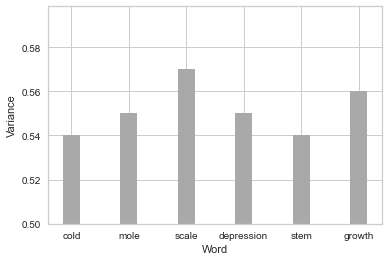

In [43]:
plt.figure(figsize=(6, 4))
y_pos = np.arange(len(var_pol_lb))
plt.bar(y_pos, var_pol, width=[0.3], color=['darkgray'])
# Create names on the x-axis
plt.xticks(y_pos, var_pol_lb)
plt.ylim(ymin=0.5)  # this line
plt.ylabel('Variance')
plt.xlabel('Word')
plt.savefig("polysemy-var.png")
# Show graphic
plt.show()

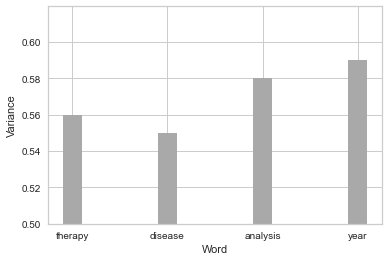

In [44]:
plt.figure(figsize=(6, 4))
y_pos = np.arange(len(var_mon_lb))
plt.bar(y_pos, var_mon, width=[0.2], color=['darkgray'])
# Create names on the x-axis
plt.xticks(y_pos, var_mon_lb)
plt.ylim(ymin=0.5)  # this line
plt.ylabel('Variance')
plt.xlabel('Word')
plt.savefig("monosemy-var.png")
# Show graphic
plt.show()

In [ ]:
colors=['darkgray','gray','dimgray','lightgray']
df.plot(kind='bar',color=colors )
plt.show()